In [ ]:
import uproot
import sys
import glob
import os
import struct
import time
import csv
import pickle
import math
import gc
import pandas as pd
# import sympy
import numpy             as np
import matplotlib.pyplot as plt

#pyTorch libraries
import torch
from torch import nn
import torch.optim as optim
import torchbnn as bnn

#Displaying images
from IPython.core.display import display, HTML, Image

import scipy
from   scipy             import interpolate
from   scipy.interpolate import CubicSpline, splev, splrep, interp1d, PPoly
from   scipy.optimize    import curve_fit, least_squares, minimize
from   scipy.signal      import find_peaks

import matplotlib             as mpl
import matplotlib.pyplot      as plt

#Plotting Config
mpl.rcParams["axes.facecolor"] = "#EAEAF2" 
mpl.rcParams['figure.dpi']     = 100 
mpl.rcParams['savefig.dpi']    = 100 

#import jtplot
from jupyterthemes import jtplot
# you can select an alternative theme's plot style by name
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style('grade3')

# Simple Classification 

## Data

In [2]:
#Iris data from sklearn
from sklearn import datasets

In [ ]:
#Iris data
#    -3types of irises: petal length, petal width, sepal lengths, and sepal width in 150x4 array
iris = datasets.load_iris()

#Data with features
X = iris.data
Y = iris.target

#Into torch tensors
x = torch.from_numpy(X).float()
y = torch.from_numpy(Y).long()

print(f"x.shape = {x.shape}\t y.shape = {y.shape}")

## Build Model

In [4]:
#Model
model = nn.Sequential(bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=4, out_features=100), 
                      nn.ReLU(), 
                      bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=3))

In [5]:
#Loss fn
#    -Cross entropy loss
#    -KL divergence of bayesian neural network
ce_loss = nn.CrossEntropyLoss()
kl_loss = bnn.BKLLoss(reduction="mean", last_layer_only=False)

#Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [6]:
#Train and predict
kl_weight = 0.1

for step in range(3000):
    pre  = model(x)
    ce   = ce_loss(pre, y)
    kl   = kl_loss(model)
    cost = ce + kl_weight*kl 
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
_, predicted = torch.max(pre.data, 1)
total        = y.size(0)
correct      = (predicted == y).sum()

print(f"- Accuracy: {100*float(correct)/total:f}")
print(f"- CE: {ce.item():2.2f}, \t KL: {kl.item():2.2f}")

- Accuracy: 97.333333
- CE: 0.10, 	 KL: 1.30


C:\Users\musta\AppData\Local\Temp\ipykernel_5700\4266483374.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(z1_plot,ax=ax1)
C:\Users\musta\AppData\Local\Temp\ipykernel_5700\4266483374.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(z2_plot,ax=ax2)


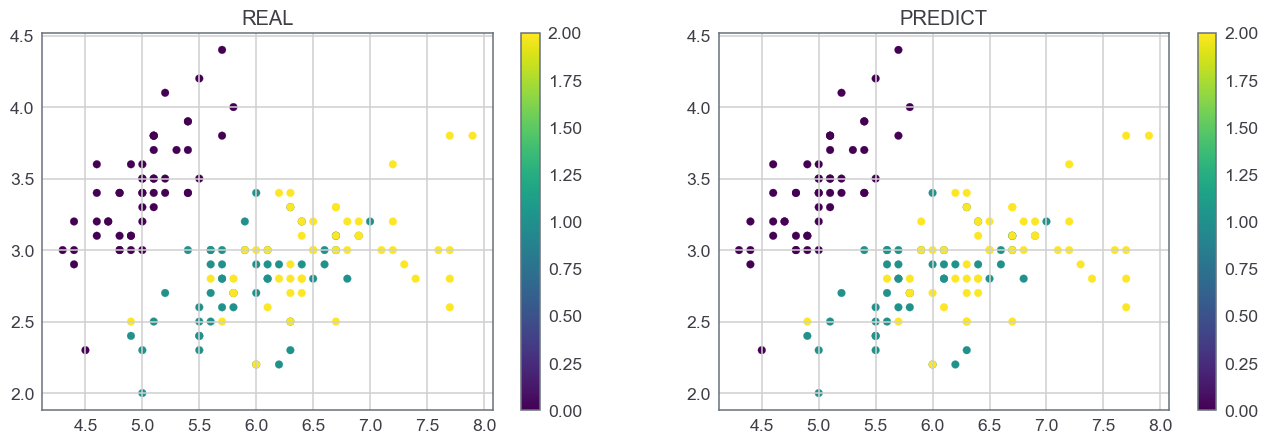

In [25]:
#Plot
def draw_plot(predicted) :
    fig = plt.figure(figsize = (16, 5))
    
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    
    z1_plot = ax1.scatter(X[:, 0], X[:, 1], c = Y)
    z2_plot = ax2.scatter(X[:, 0], X[:, 1], c = predicted)
    
    plt.colorbar(z1_plot,ax=ax1)
    plt.colorbar(z2_plot,ax=ax2)
    
    ax1.set_title("REAL")
    ax2.set_title("PREDICT")
    
    plt.show()

pre = model(x)
_, predicted = torch.max(pre.data, 1)
draw_plot(predicted)


C:\Users\musta\AppData\Local\Temp\ipykernel_5700\4266483374.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(z1_plot,ax=ax1)
C:\Users\musta\AppData\Local\Temp\ipykernel_5700\4266483374.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(z2_plot,ax=ax2)


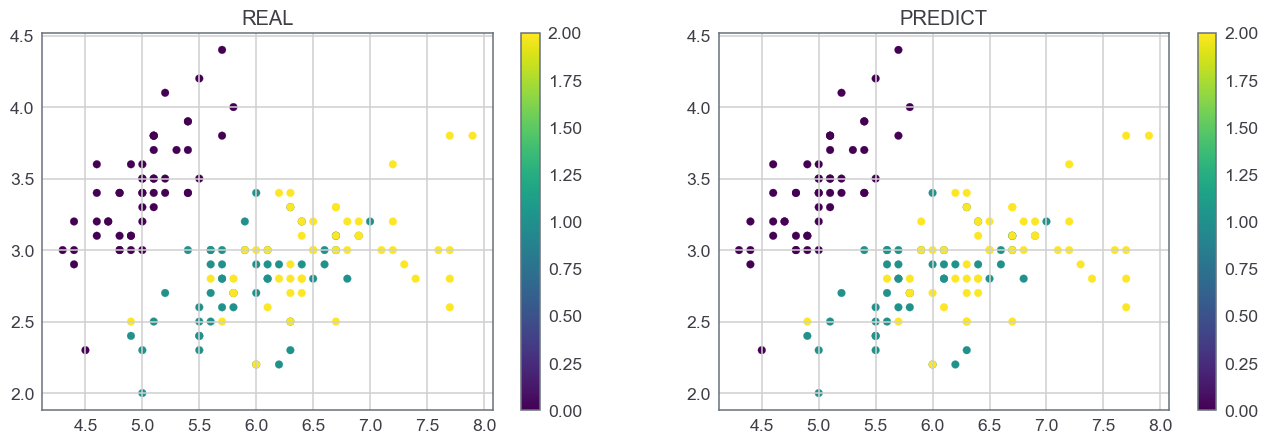

In [26]:
# Bayesian Neural Network will return different outputs even if inputs are same.
# In other words, different plots will be shown every time forward method is called.
pre = model(x)
_, predicted = torch.max(pre.data, 1)
draw_plot(predicted)

# Martin's Uncertainty Quantification

* Bayesian NN provides a mathematical framework to quantize the model uncertainty, unlike the standard pointwise deep learning tools

* Comes with prohibitive computational cost

# ETC 